In [12]:
import sqlite3

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

sns.set_style("darkgrid")
float_formatter = "{:.5}".format
np.set_printoptions(formatter={"float_kind": float_formatter})


### Load Data from the database

In [13]:
def dict_factory(cursor, row):
    col_names = [col[0] for col in cursor.description]
    return {key: value for key, value in zip(col_names, row)}


query1 = """
    SELECT
        g.result,
        g.url,
        p.eval,
        p.ply,
        g.elo_white - g.elo_black as elo_dif,
        1 as weight
    FROM
        games g INNER JOIN positions p
        ON g.rowid = p.game_id
    WHERE
        g.result != 0
        AND p.eval is not NULL
    """

query2 = """
    SELECT 
        g.result,
        g.elo_white - g.elo_black as elo_dif
    FROM games g
    WHERE g.result != 0
    """

query3 = """
    SELECT 
        p.eval,
        COUNT(g.url)
    FROM positions p JOIN games g
    ON g.rowid = p.game_id
    GROUP BY g.url
    """

with sqlite3.connect("games.sqlite") as con:
    con.row_factory = dict_factory
    res = con.execute(query1)
    data = pd.DataFrame(res)

con.close()


### Weight moves by number of moves in each game

In [14]:
g = data.groupby("url").count()
data2 = data.merge(g.result, on="url", suffixes=("", "_y"))
data2.weight = data2.weight / data2.result_y


In [16]:
data_plot = data[]
sns.regplot(
    data=(data + 1) / 2,
    x="eval",
    y="result",
    y_jitter=0.05,
    x_jitter=0.2,
    logistic=True,
    n_boot=1,
    ci=1,
    scatter_kws={"s": 0.5, "color": "lightgreen"},
    color="slateblue",
)


### Define the steps in the analysis pipeline

In [116]:
random_state = 42

features = [
    "eval",
    # "ply",
    # "elo_dif",
]

X = data2[features]
y = data2.result
weights = data2.weight * 55_000 / 700

X_train, X_test, y_train, y_test, weights_train, weights_test = train_test_split(
    X, y, weights, random_state=random_state, stratify=y
)

scaler = StandardScaler(
    with_mean=False,
)

classifier = LogisticRegressionCV(
    # Cs=20,
    Cs=[1],
    random_state=random_state,
    n_jobs=-1,
    penalty="elasticnet",
    solver="saga",
    l1_ratios=np.linspace(0, 1, num=10),
    fit_intercept=False,
    class_weight="balanced",
)

model = Pipeline(
    steps=[
        ("scaler", scaler),
        ("classifier", classifier),
    ]
)

model.fit(X_train, y_train, classifier__sample_weight=weights_train)


Pipeline(steps=[('scaler', StandardScaler(with_mean=False)),
                ('classifier',
                 LogisticRegressionCV(Cs=[1], class_weight='balanced',
                                      fit_intercept=False,
                                      l1_ratios=array([0.0, 0.11111, 0.22222, 0.33333, 0.44444, 0.55556, 0.66667, 0.77778,
       0.88889, 1.0]),
                                      n_jobs=-1, penalty='elasticnet',
                                      random_state=42, solver='saga'))])

### Show resulting coefficients

In [57]:
print(f"Accuracy: \n {model.score(X_test, y_test, sample_weight=weights_test)}")
scale = model.named_steps["scaler"].scale_
mean = model.named_steps["scaler"].mean_
print(f"Mean: \n {mean}")

coefs = model.named_steps["classifier"].coef_ / scale
print(f"Coefficients: \n {coefs}")

intercept = model.named_steps["classifier"].intercept_
print(f"Intercept: \n {intercept}")

cs = model.named_steps["classifier"].C_
print(f"Regularization strenght: \n {cs}")

l1_ratio = model.named_steps["classifier"].l1_ratio_
print(f"L1 Ratio: {l1_ratio}")


Accuracy: 
 0.6231074092497062
Mean: 
 [-6.7853]
Coefficients: 
 [[0.0060177]]
Intercept: 
 [0.0]
Regularization strenght: 
 [1]
L1 Ratio: [0.0]


### Show results

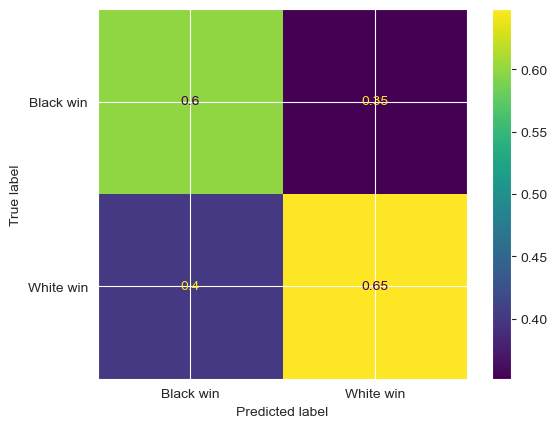

In [58]:
ConfusionMatrixDisplay.from_estimator(
    model,
    X_test,
    y_test,
    sample_weight=weights_test,
    normalize="pred",
    display_labels=[
        "Black win",
        # "Draw",
        "White win",
    ],
)


In [59]:
def p(X, exponent, intercept):
    p = 1 / (1 + np.exp(-X * exponent - intercept))
    return p


In [60]:
model.predict_proba([[100]])


c:\tools\miniconda3\envs\py310\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


array([[0.35394, 0.64606]])

In [61]:
p(100, coefs, intercept)


array([[0.64606]])

### Plots

C:\Users\Sandro\AppData\Local\Temp\ipykernel_23188\2183986408.py:9: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data_plot.loc[:,"result"] = (data_plot.loc[:,"result"] + 1).copy() / 2


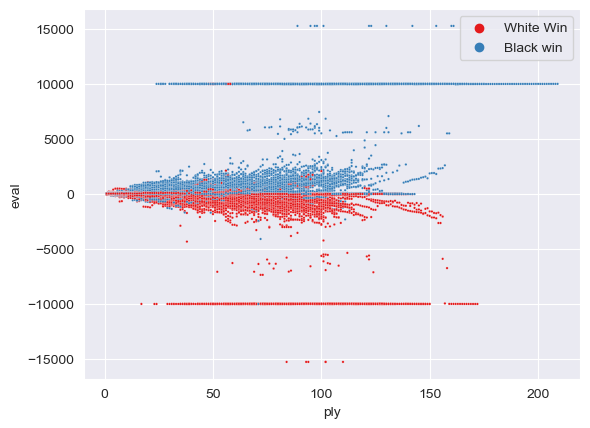

In [115]:
pd.set_option("mode.chained_assignment", None)

data_plot = data[["eval", "ply", "elo_dif", "result"]]
data_plot.loc[:, "result"] = (data_plot.loc[:, "result"] + 1).copy() / 2

g = sns.scatterplot(
    data_plot,
    x="ply",
    y="eval",
    hue="result",
    s=3,
    palette="Set1",
)
legend = ["White Win", "Black win"]
handles, labels = g.get_legend_handles_labels()
g.legend(handles, legend)

plt.savefig("images\\tmp\\ply_eval.png", dpi=300, transparent=False)


c:\tools\miniconda3\envs\py310\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


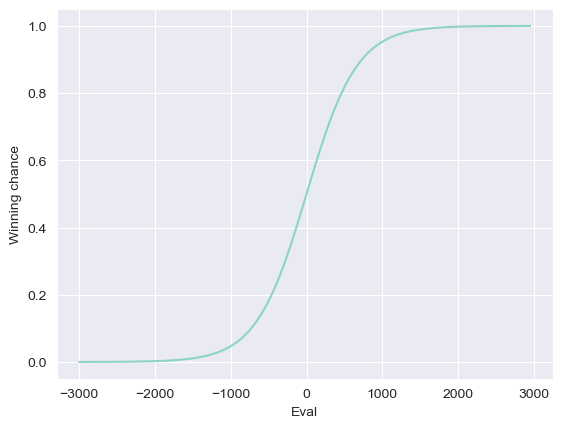

In [138]:
cps = np.arange(-3_000, 3_000, 50)
data_plot = pd.DataFrame(
    [cps, model.predict_proba(cps.reshape(-1, 1))[:, 1]],
    index=["Eval", "Winning chance"],
).T
sns.lineplot(data=data_plot, x="Eval", y="Winning chance")
plt.savefig("images\\tmp\\eval_winchance.png", dpi=300, transparent=False)